In [5]:
# 코랩 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving vgames2.csv to vgames2.csv


In [4]:
! pip install scikit_posthocs
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
import scikit_posthocs as sp
from sklearn.linear_model import LinearRegression

     |████████████████████████████████| 43 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37902 sha256=9284a463b93314c5e4b323fcc16164afbbc5812ef11cbf20cce1fc0a291358e9
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


In [60]:
# 기초 전처리
data = "vgames2.csv"
df = pd.read_csv(data)

# 출고량의K를 천단위로, M을 백만단위로 치환하는 함수 
def to_int(input):
    if (input.find("K") == -1) & (input.find("M") == -1):  
        return float(input)
    elif input.find("M") != -1 :
        return float(input.replace("M",""))
    else: 
        return float(input.replace("K",""))*0.001

# 출고량을 숫자형 변수로 변환
for i in list(df.columns)[-4:]:
    df[i] = df[i].apply(to_int)

# 불필요한 열 제거
df = df.drop("Unnamed: 0", axis=1) 

# 총 출고량 변수 생성
df["Total_Sales"]=df.iloc[:,-4:].sum(axis=1)

# 출고 비율 변수 생성
for i in ["NA","EU","JP","Other"]:
    df[f"{i}_ratio"] = df[f"{i}_Sales"]/df["Total_Sales"]

# 연도 결측값은 해당 출시 플랫폼의 평균 출시연도로 대체
df_plat = df.groupby("Platform").Year.mean()    
df.iloc[:,1:3] = df.iloc[:,1:3].fillna(method="ffill",axis=1)  
pltfrms = set(df['Platform'])
def platform_mean(input):
    if input in pltfrms:
        return df_plat[input]
    else:
        return float(input)

# 나올수 없는 값 정리
def year(input):
    if input < 22:
        return 2000 + input
    elif 22 <= input < 100:
        return 1900 + input
    else:
        return input 

# 연도변수 변수형태 저장
df["Year"] = df["Year"].apply(platform_mean)  
df["Year"] = df["Year"].apply(year)  
df["Year"] = df["Year"].apply(lambda x : int(x))

# 계산의 편의를 위한 행 추가
df["count"] = 1

# 나올수 없는 값 정리(도메인 지식 활용)
df.loc[6906,"Year"] = 2009
df.loc[5310,"Year"] = 2016
df.loc[10107,"Year"] = 2016
df.loc[15233,"Year"] = 2016
df.iloc[3031,2] = 1997

# 계산의 편의를 위한 작업 2
df3 = df.copy()
def kill(x):
    gss = ['Nintendo',
           'Electronic Arts',
           'Activision',
           'Sony Computer Entertainment',
           'Ubisoft',
           'Take-Two Interactive',
           'THQ',
           'Konami Digital Entertainment',
           'Sega',
           'Namco Bandai Games']
    if x in gss:
        return  1        
    else:
        return  0
df3["Publisher"] = df3["Publisher"].apply(kill)
df3 = df3.loc[df3["Publisher"]==1]

# 결측값 제거
df = df.dropna()

# 플랫폼의 발매연도보다 먼저 나온 case를 플랫폼의 발매연도로 만들기
dict_for_real_platform = {
                    "GB" : 1989,
                    "SNES" : 1990,
                    "N64" : 1996,
                    "DS" : 2004,
                    "GG" : 1990,
                    "PCFX" : 1994,
                    "3DS" : 2011,
                    "Wii" : 2006,
                    "XOne" : 2013,
                    "NG" : 1990,
                    "PSV" : 2011,
                    'PS3' : 2006,
                    "WiiU" : 2012,
                    'PC' : 1984,
                    'GC': 2001,
                    '2600': 1980,
                    "PSP" : 2004,
                    "3DO" : 1993,
                    "PS2" : 2000,
                    "GBA" : 2001,
                    "PS4" : 2013,
                    "GEN" : 1990,
                    "DC" : 1998,
                    "WS" : 1999,
                    "SCD" : 1991,
                    "SAT" : 1992,
                    "X360" : 2005,
                    "XB" : 2001,
                    "NES" : 1983,
                    'TG16' : 1987,
                    "PS" : 1994
                    }

df2 = df.copy()
for platform in set(df["Platform"]):
    df2.loc[((df2["Platform"]==platform) & (df2["Year"] < dict_for_real_platform[platform])), "Year"] = dict_for_real_platform[platform]

#지역별 선호하는 장르 범주형 변수 like 생성
df = df2.reset_index(drop=True)
for i in range(df.shape[0]):
    if max([df.loc[i,f"{ii}_ratio"] for ii in ["NA","EU","JP","Other"]]) == df.loc[i,f"NA_ratio"] :
        df.loc[i,"like"] = "NA"
    elif max([df.loc[i,f"{ii}_ratio"] for ii in ["NA","EU","JP","Other"]]) == df.loc[i,f"EU_ratio"] :
        df.loc[i,"like"] = "EU"
    elif max([df.loc[i,f"{ii}_ratio"] for ii in ["NA","EU","JP","Other"]]) == df.loc[i,f"JP_ratio"] :
        df.loc[i,"like"] = "JP"           
    else:
        df.loc[i,"like"] = "Other"




    

# 결측값 확인
df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Total_Sales    0
NA_ratio       0
EU_ratio       0
JP_ratio       0
Other_ratio    0
count          0
like           0
dtype: int64

In [61]:
# 지역에 따라 선호하는 게임 장르가 다른가?
# 카이제곱 독립성 검정
# 카이제곱 독립성검정에서 기대도수가 5보다 작은 값이 얼마나 있는가 알아보기
a =df.groupby("like").sum()["count"]
b =df.groupby("Genre").sum()["count"]
c = []
for i in range(len(a)):
    for ii in range(len(b)):
        exp = (a[i]*b[ii])/df.shape[0]
        c.append(exp)
exp_ratio = ((np.array(c)<5).sum()/(len(a)*len(b)))*100
print(f"기대도수가 5 보다 작은 셀의 수는 전체 셀의 {exp_ratio}%이다.\n따라서 카이제곱 독립성검정을 실시할 수 있다") 

기대도수가 5 보다 작은 셀의 수는 전체 셀의 10.416666666666668%이다.
따라서 카이제곱 독립성검정을 실시할 수 있다


In [62]:
# 교차분석표 만들기
pd.pivot_table(df,values = "count",index="like",columns="Genre",aggfunc="count").fillna(0)

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
like,,,,,,,,,,,,
EU,519.0,158.0,44.0,185.0,76.0,95.0,253.0,117.0,244.0,142.0,343.0,187.0
JP,660.0,665.0,296.0,442.0,94.0,98.0,68.0,761.0,106.0,195.0,392.0,229.0
NA,2096.0,452.0,501.0,1063.0,708.0,384.0,914.0,600.0,955.0,521.0,1590.0,261.0
Other,23.0,1.0,4.0,17.0,4.0,0.0,6.0,3.0,1.0,3.0,13.0,0.0


In [63]:
# 카이제곱 독립성 검정 실시
df2 = np.array(pd.pivot_table(df,values = "count",index="like",columns="Genre",aggfunc="count").fillna(0))
ans = stats.chi2_contingency(np.array(df2), correction = False)
print(f"카이제곱 독립성 검정결과 p-value가 {ans[1]}으로 0.05보다 작다 따라서 귀무가설을 기각한다.\n지역과 장르는 독립이 아니다\n지역에 따라 선호하는 게임 장르가 다르다")

카이제곱 독립성 검정결과 p-value가 0.0으로 0.05보다 작다 따라서 귀무가설을 기각한다.
지역과 장르는 독립이 아니다
지역에 따라 선호하는 게임 장르가 다르다


In [64]:
# 지역별 선호장르 시각화
df1 = df.groupby("Genre").sum()
for i in [f"{i}_Sales" for i in ["NA","EU","JP","Other"]]:  
    df1[i] = df1[i]/df1[i].sum()
print("일본의 롤플레잉 장르 선호가 눈에 띈다")    
fig = go.Figure()
for i in [f"{i}_Sales" for i in ["NA","EU","JP","Other"]]:
    fig.add_trace(go.Scatter(x=df1.index, 
                             y=df1[i],
                             mode='lines+markers', 
                             name=i))      
df1 = df1[["Total_Sales"]]/df1["Total_Sales"].sum()

# 전체 선호장르 시각화
fig.add_trace(go.Scatter(x=df1.index, 
                         y=df1["Total_Sales"],
                         mode='lines+markers', 
                         name="Total"))                                                                                 
fig.update_layout(
    autosize=False,
    title = "지역별 장르에 따른 출고비율",
    width=900,
    height=450,)
fig.show()

일본의 롤플레잉 장르 선호가 눈에 띈다


In [65]:
# 국가별 총 출고량의 변화
fig = go.Figure()
list_for = ["Total","NA","EU","JP","Other"]
for i in [f"{Con}_Sales" for Con in list_for]:
    df1 = df.groupby("Year").sum()[i]
    fig.add_trace(go.Scatter(x = df1.index, 
                         y = df1,
                         mode='lines+markers', 
                         name=f"{i}"))
fig.update_layout(
    title = "지역별 총 출고량",
    autosize=False,
    width=900,
    height=450,)                         
fig.show()                         

In [66]:
# 연도별 출시된 게임의 수 시각화
df1 = df.groupby("Year").sum()["count"]
fig = go.Figure()
fig.add_trace(go.Scatter(x = df1.index, 
                         y = df1,
                         mode='lines+markers'
                         ))
fig.update_layout(
    title = "연도별 출시된 게임의 수",
    autosize=False,
    width=700,
    height=450,)                         
fig.show()

In [67]:
# 1980년부터 1994년까지의 선형회귀
df_80_94 = df.loc[df["Year"]<1995][["Year","Total_Sales"]]
df_80_94 = df_80_94.groupby("Year").sum().reset_index()
model_80_94 = sm.OLS.from_formula("Total_Sales ~ Year", data=df_80_94)
result = model_80_94.fit()
result.predict(df_80_94["Year"])
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Sales   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     9.278
Date:                Mon, 13 Dec 2021   Prob (F-statistic):            0.00937
Time:                        04:12:52   Log-Likelihood:                -62.337
No. Observations:                  15   AIC:                             128.7
Df Residuals:                      13   BIC:                             130.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5953.5163   1969.193     -3.023      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



In [68]:
# 1995년부터 2008년 까지의 선형회귀
df_95_08 = df.loc[(1994<df["Year"])&(df["Year"]<2009)][["Year","Total_Sales"]]
df_95_08 = df_95_08.groupby("Year").sum().reset_index()
model_95_08 = sm.OLS.from_formula("Total_Sales ~ Year", data=df_95_08)
result = model_95_08.fit()
result.predict(df_95_08["Year"])
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Sales   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     180.4
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           1.36e-08
Time:                        04:12:53   Log-Likelihood:                -71.840
No. Observations:                  14   AIC:                             147.7
Df Residuals:                      12   BIC:                             149.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.849e+04   5870.301    -13.371      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14



In [69]:
# 2009년부터 2016까지 선형회귀
df_09 = df.loc[2008<df["Year"]][["Year","Total_Sales"]]
df_09 = df_09.groupby("Year").sum().reset_index()
model_09 = sm.OLS.from_formula("Total_Sales ~ Year", data=df_09)
result = model_09.fit()
result.predict(df_09["Year"])
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Sales   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     96.88
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           6.34e-05
Time:                        04:12:55   Log-Likelihood:                -41.473
No. Observations:                   8   AIC:                             86.95
Df Residuals:                       6   BIC:                             87.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.528e+05   1.55e+04      9.868      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



In [70]:
# 회귀선 그리기
df_80_94 = df.loc[df["Year"]<1995][["Year","Total_Sales"]]
df_95_08 = df.loc[(1994<df["Year"])&(df["Year"]<2009)][["Year","Total_Sales"]]
df_09 = df.loc[2008<df["Year"]][["Year","Total_Sales"]]
fig = go.Figure()
for i in ["80_94", "95_08", "09"]:
  globals()["df_{}".format(i)] = globals()["df_{}".format(i)].groupby("Year").sum().reset_index()
  X = globals()["df_{}".format(i)]["Year"]
  y = globals()["df_{}".format(i)]["Total_Sales"]
  line_fitter = LinearRegression()
  line_fitter.fit(X.values.reshape(-1,1), y)
  line_fitter.predict(X.values.reshape(-1,1))
  fig.add_trace(go.Scatter(x=X, 
                          y=line_fitter.predict(X.values.reshape(-1,1)),
                        mode='lines+markers',
                         name=i))
df1 = df.groupby("Year").sum()[['Total_Sales']]
fig.add_trace(go.Scatter(x=df1.index, 
                         y=df1['Total_Sales'],
                         mode='lines+markers',
                         name="전체 판매량"))
fig.update_layout(
    title = "게임 출고량의 변화",
    autosize=False,
    width=900,
    height=450,)                         
print("기울기의 변화는 다음과 같다: [3.731, 38.8503, -76.0429]")
fig.show()


기울기의 변화는 다음과 같다: [3.731, 38.8503, -76.0429]


In [71]:
# 장르별 연도에 따른 출고량의 변화
fig = go.Figure()
for i in list(df["Genre"].value_counts().index):
    df1 = (df.loc[df["Genre"]==i].
            groupby("Year").
            sum()["Total_Sales"]/
            df.groupby("Year").
            sum()["Total_Sales"])
    fig.add_trace(go.Scatter(x=df1.index, 
                             y=df1,#["Total_Sales"],
                             mode='lines+markers', # Line plot만 그리기
                             name=i))                                                          
fig.update_layout(
    autosize=False,
    title = "장르별 연도당 게임 출고량 비율",
    width=1000,
    height=450,)
fig.show()

In [72]:
# 플랫폼별 연도당 게임 출고량
fig = go.Figure()
df1 = df.groupby("Year").sum()[['Total_Sales']]
fig.add_trace(go.Scatter(x=df1.index, 
                         y=df1['Total_Sales'],
                         mode='lines+markers',
                         name="전체 출고량"))
for i in list(df["Platform"].value_counts().index)[:-9]:                                                          
    df1 = df.loc[df["Platform"]==i].groupby("Year").sum()
    fig.add_trace(go.Scatter(x=df1.index, y=df1['Total_Sales'],
                    mode='lines+markers', 
                    name=i))                                                                    
fig.update_layout(
    title = "플랫폼별 연도당 게임 출고량",
    autosize=False,
    width=900,
    height=450,)
fig.show()

In [73]:
# 퍼블리셔별 연도당 게임 출고량

fig = go.Figure()

df1 = (df.
       groupby("Year").
       sum()[['Total_Sales']])

fig.add_trace(go.Scatter(x=df1.index, y=df1['Total_Sales'],
                    mode='lines+markers', 
                    name="전체 출고량"))

list_for_publish = list(df.
                        groupby("Publisher").
                        sum().
                        sort_values(by="Total_Sales",
                        ascending=False).
                        iloc[:10,:].
                        index)

for i in list_for_publish :                                                          
    df1 = (df.
           loc[df["Publisher"]==i].
           groupby("Year").
           sum())
    fig.add_trace(go.Scatter(x = df1.
                                 index, 
                             y=df1['Total_Sales'],
                             mode='lines+markers', 
                             name=i))     

fig.add_trace(go.Scatter(x = df3.
                             loc[df3["Publisher"]==1].
                             groupby("Year").
                             sum()["Total_Sales"].
                             index, 
                         y = df3.
                             loc[df3["Publisher"]==1].
                             groupby("Year").
                             sum()["Total_Sales"],
                         mode='lines+markers', 
                         name="상위 10개 퍼블리셔의 연도당 게임 출고량"))                                                                                   

fig.update_layout(
    title = "퍼블리셔별 연도당 게임 출고량",
    autosize=False,
    width=900,
    height=450,)
fig.show()             

In [74]:
# 밀리언셀러들에 대한 분석과 시각화
df_million = df.loc[df["Total_Sales"]>=1]
df_million

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,NA_ratio,EU_ratio,JP_ratio,Other_ratio,count,like
20,Ty the Tasmanian Tiger,PS2,2002,Platform,Electronic Arts,0.57,0.45,0.00,0.15,1.17,0.487179,0.384615,0.000000,0.128205,1,NA
24,Injustice: Gods Among Us,PS3,2013,Fighting,Warner Bros. Interactive Entertainment,0.48,0.53,0.01,0.23,1.25,0.384000,0.424000,0.008000,0.184000,1,EU
31,Rock Band,X360,2005,Misc,Electronic Arts,1.93,0.34,0.00,0.21,2.48,0.778226,0.137097,0.000000,0.084677,1,NA
58,Bomberman,NES,1985,Puzzle,Hudson Soft,0.18,0.00,0.85,0.00,1.03,0.174757,0.000000,0.825243,0.000000,1,JP
65,Kirby: Mass Attack,DS,2011,Platform,Nintendo,0.52,0.06,0.41,0.05,1.04,0.500000,0.057692,0.394231,0.048077,1,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16455,Wall-E,Wii,2008,Platform,THQ,0.51,0.40,0.00,0.11,1.02,0.500000,0.392157,0.000000,0.107843,1,NA
16465,Finding Nemo,PS2,2003,Action,THQ,1.26,0.60,0.05,0.18,2.09,0.602871,0.287081,0.023923,0.086124,1,NA
16467,Grand Theft Auto V,PC,2015,Action,Take-Two Interactive,0.36,0.64,0.00,0.08,1.08,0.333333,0.592593,0.000000,0.074074,1,EU
16475,LEGO Indiana Jones 2: The Adventure Continues,Wii,2009,Action,Activision,0.91,0.39,0.00,0.13,1.43,0.636364,0.272727,0.000000,0.090909,1,NA


In [75]:
# 기술통계량
df_million.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,NA_ratio,EU_ratio,JP_ratio,Other_ratio,count
count,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.0
mean,2004.620823,1.340838,0.798770,0.345884,0.256557,2.742048,0.493673,0.286798,0.125826,0.093702,1.0
std,7.247898,1.968405,1.223602,0.777054,0.475788,3.656774,0.225271,0.177457,0.233951,0.087077,0.0
min,1980.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2001.000000,0.570000,0.270000,0.000000,0.070000,1.270000,0.363469,0.154639,0.000000,0.039427,1.0
50%,2006.000000,0.900000,0.500000,0.030000,0.150000,1.710000,0.500000,0.293839,0.012270,0.083333,1.0
75%,2010.000000,1.490000,0.930000,0.340000,0.270000,2.820000,0.630000,0.384615,0.149837,0.126492,1.0
max,2016.000000,41.490000,29.020000,10.220000,10.570000,82.740000,1.000000,1.000000,1.000000,0.893939,1.0


In [76]:
# 총 출고량의 분포
import plotly.express as px
fig = px.histogram(df_million, x="Total_Sales")
fig.show()

In [77]:
# 밀리언셀러의 플랫폼별 총 출고량
df_million_platform_sum = df_million.groupby("Platform").sum()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False)
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_platform_sum.index, y=df_million_platform_sum["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 플랫폼별 총 출고량",
    autosize=False,
    width=900,
    height=450,)
fig.show()   

In [78]:
# 밀리언셀러의 플랫폼별 평균 출고량
df_million_platform_mean = df_million.groupby("Platform").median()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False)
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_platform_mean.index, y=df_million_platform_mean["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 플랫폼별 출고량 중위수",
    autosize=False,
    width=900,
    height=450,)
fig.show() 

In [79]:
# 밀리언셀러의 퍼블리셔별 총 출고량 상위15개
df_million_publisher_sum = df_million.groupby("Publisher").sum()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False).iloc[:15,:]
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_publisher_sum.index, y=df_million_publisher_sum["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 퍼블리셔별 총 출고량 상위15개",
    autosize=False,
    width=900,
    height=450,)
fig.show() 

In [80]:
# 밀리언셀러의 퍼블리셔별 평균 출고량 상위15개
df_million_publisher_mean = df_million.groupby("Publisher").median()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False).iloc[:15,:]
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_publisher_mean.index, y=df_million_publisher_mean["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 퍼블리셔별 출고량 중위수 상위15개",
    autosize=False,
    width=900,
    height=450,)
fig.show() 

In [81]:
# 밀리언셀러의 장르별 총 출고량
df_million_genre_sum = df_million.groupby("Genre").sum()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False).iloc[:15,:]
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_genre_sum.index, y=df_million_genre_sum["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 장르별 총 출고량",
    autosize=False,
    width=900,
    height=450,)
fig.show() 

In [82]:
# 밀리언셀러의 장르별 평균 출고량
df_million_genre_mean = df_million.groupby("Genre").mean()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False).iloc[:15,:]
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_genre_mean.index, y=df_million_genre_mean["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 장르별 평균 출고량",
    autosize=False,
    width=900,
    height=450,)
fig.show()

In [83]:
# 밀리언셀러의 장르별 출고량의 중위수
df_million_genre_median = df_million.groupby("Genre").median()[["Total_Sales"]].sort_values(by="Total_Sales",ascending=False).iloc[:15,:]
fig = go.Figure()
fig.add_trace(go.Bar(x=df_million_genre_median.index, y=df_million_genre_median["Total_Sales"]))
fig.update_layout(
    title = "밀리언셀러의 장르별 출고량의 중위수",
    autosize=False,
    width=900,
    height=450,)
fig.show()

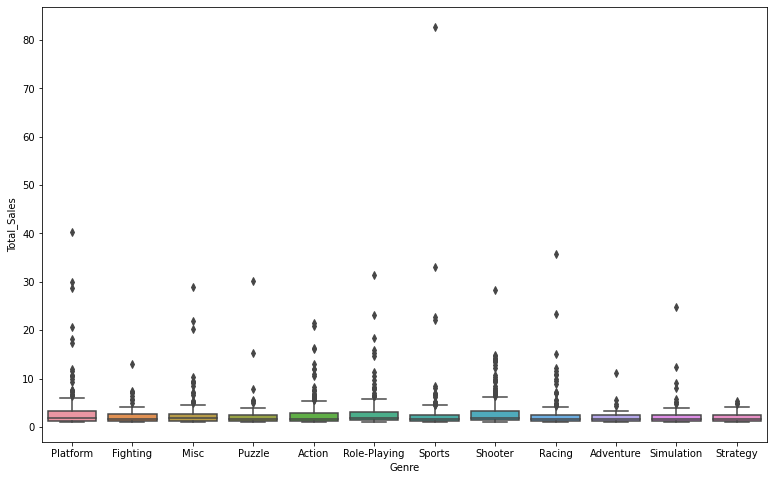

In [84]:
# 상자그림
df_million[["Genre","Total_Sales"]]
plt.figure(figsize=(13,8))
ax = sns.boxplot(x='Genre', y='Total_Sales',data=df_million[["Genre","Total_Sales"]]) # 상자그림

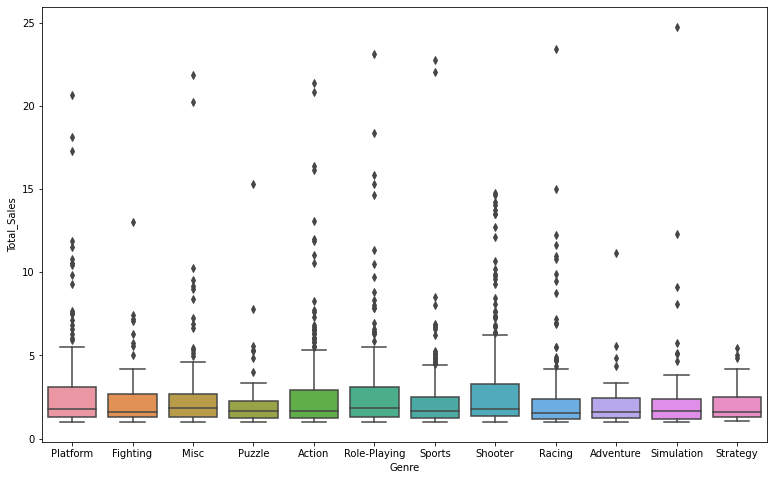

In [85]:
# 극단이상값인 wii sport 제외하고 그린 상자그림
df_million_del_wii = df_million.loc[df_million["Total_Sales"]<25]
plt.figure(figsize=(13,8))
ax = sns.boxplot(x='Genre', y='Total_Sales',data=df_million_del_wii[["Genre","Total_Sales"]])

In [86]:
# 등분산검정
data_ = [df_million.loc[ids, 'Total_Sales'].
        values for ids in df_million.
        groupby('Genre').
        groups.
        values()]
stats.levene(*data_)

LeveneResult(statistic=1.3653626473395328, pvalue=0.18263054621832658)

In [87]:
# 비모수적 분산분석
data_ = [df_million.loc[ids, 'Total_Sales'].
        values for ids in df_million.
        groupby('Genre').
        groups.values()]
stats.kruskal(*data_)

KruskalResult(statistic=21.49290279107972, pvalue=0.028609581872121332)

In [88]:
# 다중비교 던의 방법
sp.posthoc_dunn(df_million[["Genre","Total_Sales"]], val_col="Total_Sales", group_col="Genre")

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Action,1.000000,0.400374,0.438994,0.396021,0.162867,0.658547,0.103432,0.083226,0.069880,0.270974,0.429500,0.689355
Adventure,0.400374,1.000000,0.756173,0.214781,0.129449,0.726265,0.952672,0.091886,0.090816,0.960716,0.645099,0.798218
Fighting,0.438994,0.756173,1.000000,0.186847,0.082573,0.920556,0.578162,0.046923,0.042360,0.737488,0.852078,0.979505
Misc,0.396021,0.214781,0.186847,1.000000,0.678436,0.365038,0.037991,0.494107,0.499287,0.114965,0.154402,0.437663
Platform,0.162867,0.129449,0.082573,0.678436,1.000000,0.227662,0.010095,0.781810,0.804295,0.049735,0.049583,0.312666
Puzzle,0.658547,0.726265,0.920556,0.365038,0.227662,1.000000,0.597320,0.163680,0.162708,0.714080,0.979293,0.960825
Racing,0.103432,0.952672,0.578162,0.037991,0.010095,0.597320,1.000000,0.004238,0.003022,0.880350,0.365068,0.717584
Role-Playing,0.083226,0.091886,0.046923,0.494107,0.781810,0.163680,0.004238,1.000000,0.964494,0.028296,0.022350,0.247770
Shooter,0.069880,0.090816,0.042360,0.499287,0.804295,0.162708,0.003022,0.964494,1.000000,0.025538,0.016902,0.250265
Simulation,0.270974,0.960716,0.737488,0.114965,0.049735,0.714080,0.880350,0.028296,0.025538,1.000000,0.576269,0.804870


In [89]:
# 다중비교 시각화 검은색이 유의
sp.posthoc_dunn(df_million[["Genre","Total_Sales"]], val_col="Total_Sales", group_col="Genre").style.background_gradient(cmap="bone")

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Action,1.000000,0.400374,0.438994,0.396021,0.162867,0.658547,0.103432,0.083226,0.069880,0.270974,0.429500,0.689355
Adventure,0.400374,1.000000,0.756173,0.214781,0.129449,0.726265,0.952672,0.091886,0.090816,0.960716,0.645099,0.798218
Fighting,0.438994,0.756173,1.000000,0.186847,0.082573,0.920556,0.578162,0.046923,0.042360,0.737488,0.852078,0.979505
Misc,0.396021,0.214781,0.186847,1.000000,0.678436,0.365038,0.037991,0.494107,0.499287,0.114965,0.154402,0.437663
Platform,0.162867,0.129449,0.082573,0.678436,1.000000,0.227662,0.010095,0.781810,0.804295,0.049735,0.049583,0.312666
Puzzle,0.658547,0.726265,0.920556,0.365038,0.227662,1.000000,0.597320,0.163680,0.162708,0.714080,0.979293,0.960825
Racing,0.103432,0.952672,0.578162,0.037991,0.010095,0.597320,1.000000,0.004238,0.003022,0.880350,0.365068,0.717584
Role-Playing,0.083226,0.091886,0.046923,0.494107,0.781810,0.163680,0.004238,1.000000,0.964494,0.028296,0.022350,0.247770
Shooter,0.069880,0.090816,0.042360,0.499287,0.804295,0.162708,0.003022,0.964494,1.000000,0.025538,0.016902,0.250265
Simulation,0.270974,0.960716,0.737488,0.114965,0.049735,0.714080,0.880350,0.028296,0.025538,1.000000,0.576269,0.804870
